# Util functions

In [19]:
import os

def get_method_name(log_path: str) -> str:
    file_name = os.path.splitext(os.path.basename(log_path))[0]
    file_name_split = file_name.split('_')
    
    if file_name_split[4] == 'EDF':
        method_name = 'EDF'
    else:
        method_name = file_name_split[1]

    return method_name

In [20]:
from typing import Dict, List

def get_classification(log: Dict) -> str:
    if 'deadline_miss' in log.keys() and 'early_detection' in log.keys():
        classification = 'TP'
    elif 'deadline_miss' not in log.keys() and 'early_detection' in log.keys():
        classification = 'FP'
    elif 'deadline_miss' in log.keys() and 'early_detection' not in log.keys():
        classification = 'FN'
    elif 'deadline_miss' not in log.keys() and 'early_detection' not in log.keys():
        classification = 'TN'

    return classification

In [21]:
def get_utilization_percent(
    log_path: str,
    utilization_values: List[int]
) -> int:
    file_name = os.path.splitext(os.path.basename(log_path))[0]
    utilization_str = file_name.split('_')[-1]
    utilization = int(float(utilization_str.split('=')[1]) * 100)

    for i in range(len(utilization_values)):
        if utilization < utilization_values[0]:
            raise NotImplementedError()
        if i == len(utilization_values) - 1:
            utilization = utilization_values[-1]
            break

        if utilization_values[i] <= utilization < utilization_values[i+1]:
            utilization = utilization_values[i]
            break

    return utilization


## Plot

In [22]:
import numpy as np
import pandas as pd
import japanize_matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

line_style = ['s:', 'o:', '^:', 'D:', 'x:', 'H:', 'v:', '^:', '<:', 'p:', '>:', '1:', '2:', '3:', '4:']

def line_plot(
    df: pd.DataFrame,
    xlabel: str = '',
    ylabel: str = '',
    save_name: str = ''
) -> None:
    colors = [str(round(c, 1)) for c in np.arange(0, 0.8, 0.8/len(df))]
    cmap = ListedColormap(colors, name="custom")
    fig, ax = plt.subplots()
    df.plot(ax=ax,
            figsize=(8, 6),
            colormap=cmap,
            style=line_style[:len(df)],
            linewidth=2,
            markersize=4,
            markeredgewidth=2,
            grid=True,
            fontsize=16)
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks(np.arange(0, 1.01, 0.1))
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.legend(fontsize=13, loc='lower right')
    
    if save_name:
        plt.savefig(f'./results/figures/{save_name}')
    
    plt.show()

# Utilization varied

In [23]:
import glob
import pandas as pd
import yaml
import numpy as np

METHOD_NAMES = ['proposed', 'Igarashi', 'Saidi', 'EDF']
UTILIZATION_VALUES = [int(c) for c in np.arange(55, 100.1, 5)]
PERCENTILES = [round(p, 2) for p in np.arange(0.85, 1.001, 0.01)]

utilization_df_dict = {}
for method in METHOD_NAMES:
    for percentile in PERCENTILES:
        key = f'{method}_{percentile}'
        utilization_df_dict[key] = pd.DataFrame(index=['TP', 'FN', 'TN', 'FP'],
                                                columns=[str(u) for u in UTILIZATION_VALUES])
        utilization_df_dict[key].fillna(0, inplace=True)

In [24]:
# for percentile in PERCENTILES:
#     log_paths = glob.glob(f"./results/utilization_varied_percentile_alpha/{percentile}/*.yaml")

#     for log_path in log_paths:
#         with open(log_path, "r") as f:
#             log = yaml.safe_load(f)
        
#         method_name = get_method_name(log_path)
#         utilization = get_utilization_percent(log_path, UTILIZATION_VALUES)
#         classification = get_classification(log)
#         key = f'{method_name}_{percentile}'
#         utilization_df_dict[key].at[str(classification), str(utilization)] += 1

In [25]:
for percentile in PERCENTILES:
    log_paths = glob.glob(f"./results/utilization_varied_percentile/{percentile}/*.yaml")

    for log_path in log_paths:
        with open(log_path, "r") as f:
            log = yaml.safe_load(f)
        
        method_name = get_method_name(log_path)
        utilization = get_utilization_percent(log_path, UTILIZATION_VALUES)
        classification = get_classification(log)
        key = f'{method_name}_{percentile}'
        utilization_df_dict[key].at[str(classification), str(utilization)] += 1

# Dataframe helper

In [26]:
from typing import List

def create_utilization_df(
    source_keys: List[str],
    metrics: str
) -> pd.DataFrame:
    # Initialize df
    df = pd.DataFrame(index=source_keys, columns=[str(u) for u in UTILIZATION_VALUES])
    
    # Create df
    for key in source_keys:
        if metrics == 'precision':
            df.loc[key] = utilization_df_dict[key].loc['TP'] / (utilization_df_dict[key].loc['TP'] + utilization_df_dict[key].loc['FP'])
        elif metrics == 'recall':
            df.loc[key] = utilization_df_dict[key].loc['TP'] / (utilization_df_dict[key].loc['TP'] + utilization_df_dict[key].loc['FN'])
        elif metrics == 'specificity':
            df.loc[key] = utilization_df_dict[key].loc['TN'] / (utilization_df_dict[key].loc['TN'] + utilization_df_dict[key].loc['FP'])
        elif metrics == 'accuracy':
            df.loc[key] = ((utilization_df_dict[key].loc['TP'] + utilization_df_dict[key].loc['TN'])
                            / (utilization_df_dict[key].loc['TP'] + utilization_df_dict[key].loc['TN'] + utilization_df_dict[key].loc['FP'] + utilization_df_dict[key].loc['FN']))
        elif metrics == 'f-measure':
            recall = utilization_df_dict[key].loc['TP'] / (utilization_df_dict[key].loc['TP'] + utilization_df_dict[key].loc['FN'])
            precision = utilization_df_dict[key].loc['TP'] / (utilization_df_dict[key].loc['TP'] + utilization_df_dict[key].loc['FP'])
            df.loc[key] = ((2 * recall * precision) / (recall + precision))
        else:
            raise NotImplementedError()
    
    df = df.T
    return df

## Precision

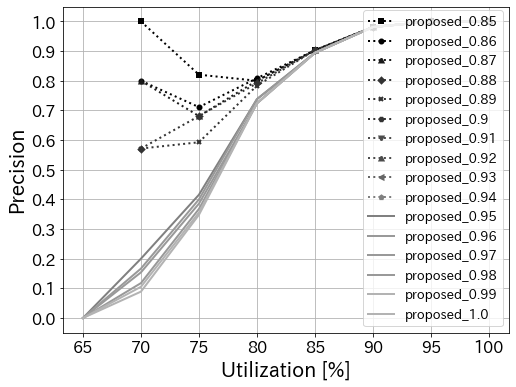

In [27]:
source_keys = [f'proposed_{p}' for p in PERCENTILES]
precision_df = create_utilization_df(source_keys, 'precision')
# precision_df
line_plot(precision_df, 'Utilization [%]', 'Precision')

## Recall

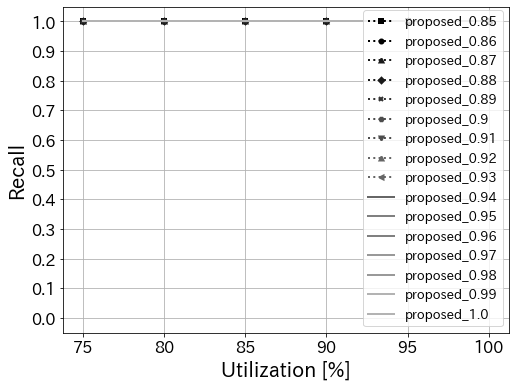

In [28]:
recall_df = create_utilization_df(source_keys, 'recall')
recall_df.drop('70', axis=0, inplace=True)
line_plot(recall_df, 'Utilization [%]', 'Recall')

## Specificity

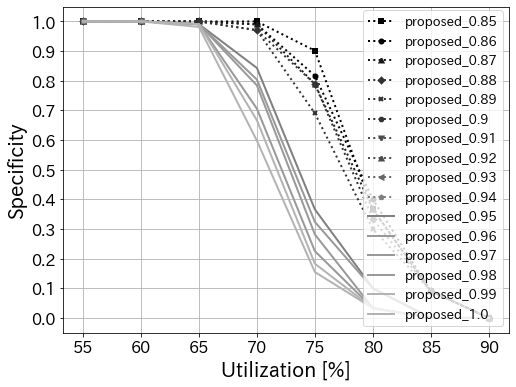

In [29]:
specificity_df = create_utilization_df(source_keys, 'specificity')
line_plot(specificity_df, 'Utilization [%]', 'Specificity')

## Accuracy

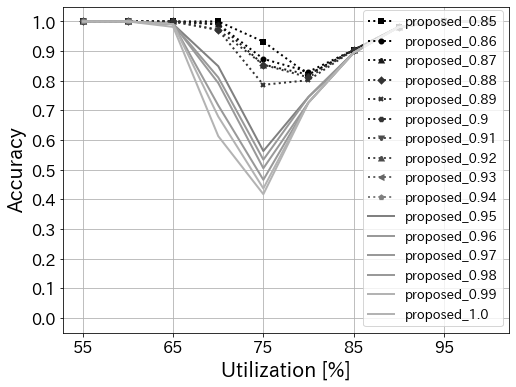

In [30]:
accuracy_df = create_utilization_df(source_keys, 'accuracy')
line_plot(accuracy_df, 'Utilization [%]', 'Accuracy')

# F-measure

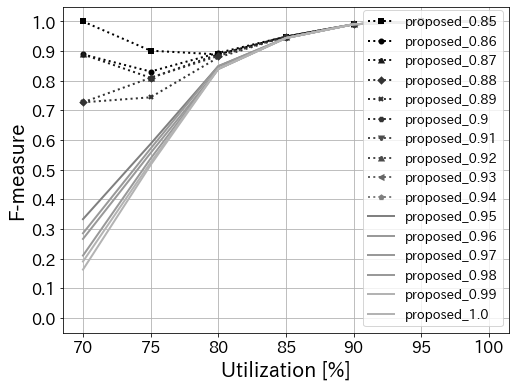

In [31]:
f_measure_df = create_utilization_df(source_keys, 'f-measure')
line_plot(f_measure_df, 'Utilization [%]', 'F-measure')